In [31]:
using DataFrames, BSON, DrWatson
using KnnOnTrees, Mill, LinearAlgebra, Statistics, Flux
using Plots, StatsPlots, Plots.PlotMeasures, StatsBase
using LIBSVM # SVM

In [2]:
# Default values
dataset = "Mutagenesis"
#df = DrWatson.collect_results(datadir("triplet", dataset), subfolders=true);

"Mutagenesis"

In [45]:
df = BSON.load("/home/zorekmat/MIL/KnnOnTrees.jl/data/triplet/Mutagenesis/1/TripletLoss-BH-Mutagenesis-seed=1-ui=1515.bson")

Dict{Symbol, Any} with 13 entries:
  :batch_size    => 16
  :train         => (ProductNode{NamedTuple{(:lumo, :inda, :logp, :ind1, :atoms…
  :ui            => 1515
  :metric        => ProductMetric ↦  WeightedProductMetric, ("*"), Weights = We…
  :learning_rate => 0.01
  :history       => Dict{String, Vector{Any}}("Validation/Loss"=>[0.688222, 0.6…
  :params        => Params([Float32[-4.11701, -3.41856, -3.41504, -4.19739], Fl…
  :val           => (ProductNode{NamedTuple{(:lumo, :inda, :logp, :ind1, :atoms…
  :test          => (ProductNode{NamedTuple{(:lumo, :inda, :logp, :ind1, :atoms…
  :gitcommit     => "d9d449616302ea3369e0c3c7b0a322d585080c37-dirty"
  :model         => mean ∘ ProductMetric ↦  WeightedProductMetric, ("*"), Weigh…
  :iters         => 5000
  :seed          => 1

In [22]:
#df = BSON.load("/home/zorekmat/MIL/KnnOnTrees.jl/data/triplet/Mutagenesis/1/TripletLoss-BH-Mutagenesis-seed=1-ui=1212.bson")

In [23]:
par_name= [
    "atoms.bond.element", "atoms.bond.bond_type", "atoms.bond.charge", "atoms.bond.atom_type", 
    "atoms.element", "atoms.bonds", "atoms.charge", "atoms.atom_type",
    "lumo", "inda", "logp", "ind1", "atoms"
];

par_names= [
    "a.b.element (cat)", "a.b.bond_type (cat)", "a.b.charge (con)", "a.b.atom_type (cat)", 
    "a.element (cat)", "a.bonds (set)", "a.charge (con)", "a.atom_type (cat)",
    "lumo (con)", "inda (cat)", "logp (con)", "ind1 (cat)", "atoms (set)"
];

In [50]:
df[:metric] |> printtree

ProductMetric ↦  WeightedProductMetric, ("*"), Weights = HMillDistance.WeightStruct(Any[:lumo, :inda, :logp, :ind1, :atoms], Float32[-7.053499, -8.190837, -8.359462, -8.169408, -4.561526], NNlib.softplus)
  ├─── lumo: LeafMetric ↦  Pairwise_Euclidean, ("2"),  Type = con
  ├─── inda: LeafMetric ↦  Pairwise_Cityblock, ("6"),  Type = cat
  ├─── logp: LeafMetric ↦  Pairwise_Euclidean, ("A"),  Type = con
  ├─── ind1: LeafMetric ↦  Pairwise_Cityblock, ("E"),  Type = cat
  ╰── atoms: SetMetric ↦  ChamferDistance, ("I") 
               ╰── ProductMetric ↦  WeightedProductMetric, ("K"), Weights = HMillDistance.WeightStruct(Any[:element, :bonds, :charge, :atom_type], Float32[-4.3083234, -3.7438388, 1.1098766, -5.0012956], NNlib.softplus)
                     ├──── element: LeafMetric ↦  Pairwise_Cityblock, ("KE"),  Type = cat
                     ├────── bonds: SetMetric ↦  ChamferDistance, ("KU") 
                     │                ╰── ProductMetric ↦  WeightedProductMetric, ("Kc"), Weights 

In [51]:
pr = map(x->vcat((x |> collect)...), df[:params]);
vcat(pr...)

13-element Vector{Float32}:
 -4.117012
 -3.4185596
 -3.4150367
 -4.197391
 -4.3083234
 -3.7438388
  1.1098766
 -5.0012956
 -7.053499
 -8.190837
 -8.359462
 -8.169408
 -4.561526

In [46]:
pr = map(x->softplus.(vcat((x |> collect)...)), df[:params]);
pr_mat= vcat(pr...)


13-element Vector{Float32}:
 0.016161816
 0.03223443
 0.03234637
 0.01492285
 0.013366362
 0.02338746
 1.3947545
 0.006706683
 0.00086400565
 0.00027714338
 0.00023414292
 0.00028314558
 0.0103919245

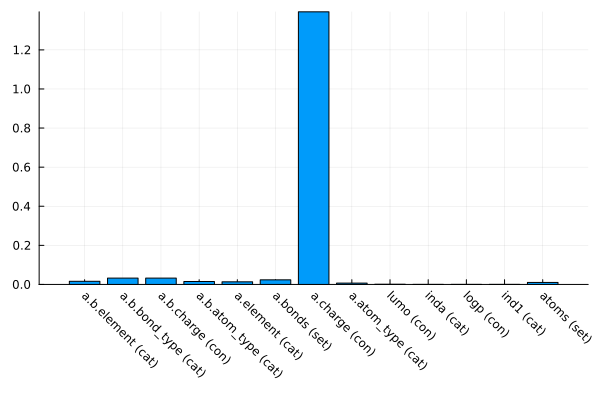

In [47]:
bar(pr_mat, xticks = (1:13, par_names), xrotation=-45, bottom_margin = 10mm, legend=false)

In [26]:
function gram_matrix(x₁, x₂, metric; verbose=true)
    js = (verbose) ? tqdm(1:length(x₂)) : 1:length(x₂)
    is = 1:length(x₁)
    dist_matrix = zeros(length(x₁), length(x₂))
    for j in js
        for  i in is
            dist_matrix[i, j] = metric(x₂[j], x₁[i])
        end
    end
    return dist_matrix
end

gram_matrix (generic function with 1 method)

In [27]:
x₁ = df[:train][1];
x₂ = df[:train][1];
m = df[:model];

In [28]:
gm_tr = gram_matrix(x₁, x₂, m, verbose=false)

113×113 Matrix{Float64}:
 1.05103e-10  0.0238847    0.0114065    …  0.0122561    0.0116354
 0.0238847    1.05103e-10  0.0212941       0.0204511    0.0211516
 0.0114065    0.0212941    1.05103e-10     0.00171571   0.00508235
 0.0254233    0.0115172    0.0210745       0.0204165    0.0206437
 0.0161061    0.0192086    0.00784218      0.00652023   0.00899033
 0.0133389    0.0207443    0.00506296   …  0.00437307   0.00641819
 0.0233951    0.00874157   0.0200422       0.0194831    0.0193096
 0.0193156    0.0124679    0.0180434       0.0181027    0.0174284
 0.0141767    0.0187882    0.00632702      0.00478454   0.00663219
 0.0232786    0.00575678   0.0193755       0.0186372    0.0189639
 0.0250539    0.00412733   0.0244738    …  0.0236768    0.0237939
 0.0196839    0.00950337   0.0182991       0.0180658    0.0181535
 0.0152137    0.0186344    0.00713406      0.00560007   0.00908839
 ⋮                                      ⋱               
 0.0143949    0.0193547    0.00630746      0.0049744   

In [29]:
x₃ = df[:val][1];
gm_valid = gram_matrix(x₁, x₃, m, verbose=false)

113×38 Matrix{Float64}:
 0.014554    0.0227206   0.0170634   …  0.0114785   0.0174899   0.021388
 0.0190667   0.00970159  0.0181785      0.0217987   0.0185768   0.027326
 0.00537337  0.0230785   0.0102129      0.00177224  0.0107379   0.0170674
 0.0197409   0.0159622   0.0197455      0.021042    0.0196799   0.0266333
 0.00506735  0.0210051   0.00512978     0.00841681  0.00673049  0.0184188
 0.00520942  0.0213451   0.0069598   …  0.00422513  0.00724056  0.0172366
 0.0190663   0.0139911   0.0199374      0.0197345   0.0192423   0.0257927
 0.0189747   0.0141107   0.0203683      0.0179955   0.0203079   0.025014
 0.00226837  0.0207706   0.00558357     0.00642492  0.00465365  0.0176506
 0.0175675   0.0105713   0.0175069      0.0194563   0.0171011   0.0253636
 0.0223766   0.0116115   0.0214251   …  0.0247198   0.0213347   0.029865
 0.0181331   0.0110223   0.0187584      0.0184581   0.0188702   0.0251689
 0.00254902  0.0214801   0.00694785     0.00814157  0.00724945  0.0183558
 ⋮                

In [30]:
x₄ = df[:test][1];
gm_test = gram_matrix(x₁, x₄, m, verbose=false)

113×37 Matrix{Float64}:
 0.0230562   0.0189095   0.0159258   …  0.0198271   0.0216387   0.0141802
 0.00787575  0.0158073   0.0190103      0.0112154   0.0269174   0.0221304
 0.0201731   0.0176396   0.00719918     0.0172564   0.017163    0.00532987
 0.0102125   0.0145075   0.0193396      0.0104433   0.0265009   0.0218324
 0.0182195   0.0201232   0.00556037     0.0181062   0.0182298   0.00785194
 0.0190708   0.0188505   0.00512178  …  0.0177097   0.0171507   0.00304215
 0.0094814   0.0128236   0.0184801      0.00885649  0.0257083   0.0209865
 0.00997946  0.00523962  0.0194235      0.00326349  0.0251013   0.0197082
 0.0182688   0.0199025   0.00200223     0.0180071   0.0173607   0.00667235
 0.00510607  0.0132212   0.0172348      0.00845878  0.0250416   0.0195448
 0.0117481   0.019382    0.0220005   …  0.0155362   0.0294931   0.0254562
 0.00595304  0.00861365  0.0184728      0.00519037  0.0250471   0.0192736
 0.0190389   0.0206735   0.00390628     0.0186333   0.0180807   0.0085927
 ⋮        

In [38]:
γ = 1/50 # one of many tried

# for triplet loss
model = svmtrain(exp.(γ .* gm_tr), df[:train][2]; kernel=LIBSVM.Kernel.Precomputed, verbose=true);

*
optimization finished, #iter = 44
nu = 0.778761
obj = -88.434645, rho = -1.009382
nSV = 88, nBSV = 88
Total nSV = 88


In [39]:
y_valid_pr, _ = svmpredict(model, exp.(γ .* gm_valid));
y_test_pr, _ = svmpredict(model, exp.(γ .* gm_test));

In [40]:
mean(y_valid_pr .== df[:val][2])

0.7368421052631579

In [41]:
mean(y_test_pr .== df[:test][2])

0.7567567567567568

In [36]:
probs = knn_predict_multiclass(gm_test, df[:train][2])

113×37 Matrix{Int64}:
 1  2  2  1  2  2  2  2  2  2  2  1  2  …  1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2  …  1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2  …  1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2     1  2  2  2  1  1  2  1  2  2  2  2
 1  2  2  1  2  2  2  2  2  2  2  1  2    

In [37]:
tr_len = length(df[:train][2]);
accuracy_tst = mean(probs .== repeat(df[:test][2], 1, tr_len)', dims=2)[:];

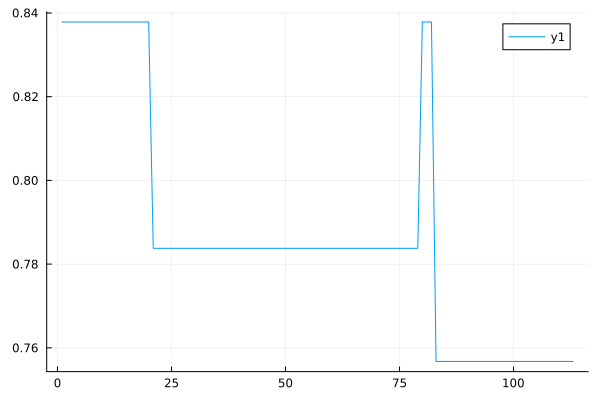

In [42]:
plot(accuracy_tst)

In [43]:
accuracy_tst[3]

0.8378378378378378